Trying to do graph classification; e.g. predict fractal dimension

In [45]:
%matplotlib inline
import torch
import pandas as pd
from torchmetrics import Accuracy, AUC, ConfusionMatrix
import seaborn as sn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from torch_cluster import knn_graph
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.datasets import make_blobs as mb
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from galpy.potential.mwpotentials import McMillan17
from sklearn.preprocessing import StandardScaler
from galpy.util.conversion import get_physical
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

In [46]:
simu = pd.read_table('sink_2.0/Sink/sink_m1.e4.dat', sep = " ")

In [47]:
np.random.seed(8) #set seed
ss = StandardScaler()
ss.fit(simu.to_numpy()[:,1:4]) #0 is mass, 1,2,3 are x, y, z
coordinates = ss.transform(simu.to_numpy()[:,1:4]) #point coordinates

In [54]:
x = torch.Tensor(coordinates)
#labels = np.random.choice([0,1], coordinates.shape[0])
#assign_train_test_val = np.random.choice(['train', 'train', 'train', 'test', 'validation'], coordinates.shape[0])
#train_mask=torch.Tensor(assign_train_test_val == 'train')
#train_mask=train_mask.type(dtype=torch.bool)
#validation_mask=torch.Tensor(assign_train_test_val == 'validation')
#validation_mask=validation_mask.type(dtype=torch.bool)
edge_index = knn_graph(x, k=4)
y = torch.Tensor(labels)
y = y.type(dtype=torch.long)
P = Data(x=x, y=y, edge_index=edge_index, train_mask=None, validation_mask=None, test_mask=None)
#data.train_mask = data.val_mask = data.test_mask = None
P = train_test_split_edges(P)

In [74]:
P

Data(x=[2523, 3], y=[2523], val_pos_edge_index=[2, 249], test_pos_edge_index=[2, 498], train_pos_edge_index=[2, 8484], train_neg_adj_mask=[2523, 2523], val_neg_edge_index=[2, 249], test_neg_edge_index=[2, 498])

Set up the autoencoder

In [81]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) 
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

from torch_geometric.nn import GAE

# parameters
out_channels = 2
num_features = P.num_features
epochs = 9000

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = P.x.to(device)
train_pos_edge_index = P.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

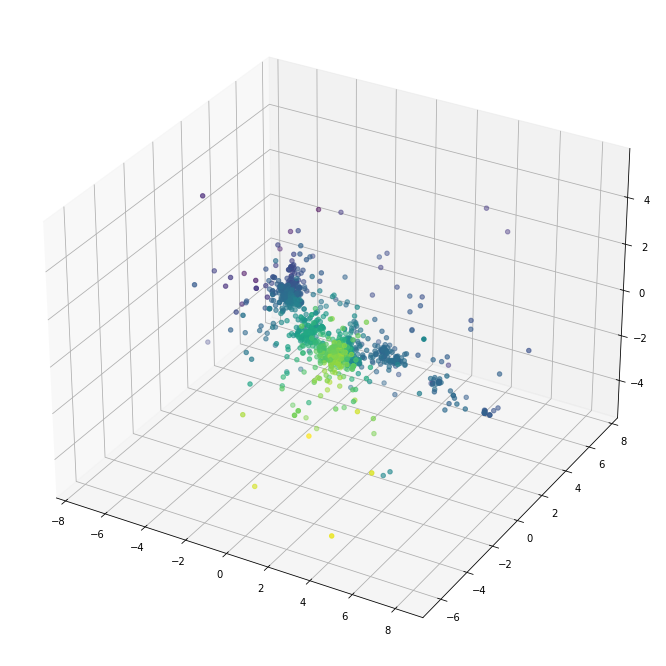

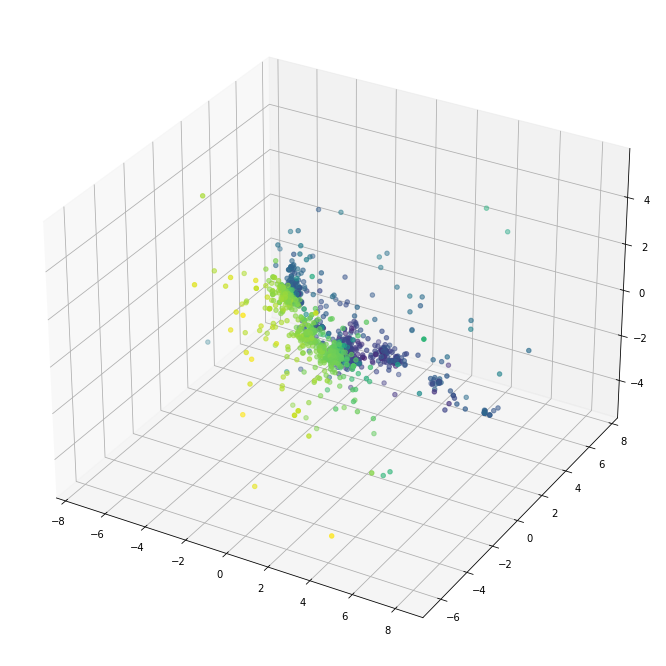

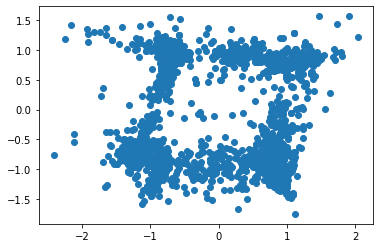

In [82]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(P.test_pos_edge_index, P.test_neg_edge_index)
    #print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Z = model.encode(x, train_pos_edge_index)
Znp = Z.detach().numpy()

#plt.scatter(simu.to_numpy()[:,1], simu.to_numpy()[:,2], c=Znp[:,0])
#plt.show()
#plt.scatter(simu.to_numpy()[:,1], simu.to_numpy()[:,3], c=Znp[:,0])
#plt.show()
#plt.scatter(simu.to_numpy()[:,2], simu.to_numpy()[:,3], c=Znp[:,0])
#plt.show()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(simu.to_numpy()[:,1], simu.to_numpy()[:,2], simu.to_numpy()[:,3],  c=Znp[:,0])
plt.show()

#plt.scatter(simu.to_numpy()[:,1], simu.to_numpy()[:,2], c=Znp[:,1])
#plt.show()
#plt.scatter(simu.to_numpy()[:,1], simu.to_numpy()[:,3], c=Znp[:,1])
#plt.show()
#plt.scatter(simu.to_numpy()[:,2], simu.to_numpy()[:,3], c=Znp[:,1])
#plt.show()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(simu.to_numpy()[:,1], simu.to_numpy()[:,2], simu.to_numpy()[:,3],  c=Znp[:,1])
plt.show()

plt.scatter(Znp[:,0], Znp[:,1])
plt.show()

In [78]:
from torch.utils.tensorboard import SummaryWriter

# parameters
out_channels = 2
num_features = P.num_features
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = P.x.to(device)
train_pos_edge_index = P.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(P.test_pos_edge_index, P.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line
    
writer

Epoch: 001, AUC: 0.7285, AP: 0.6790
Epoch: 002, AUC: 0.7158, AP: 0.6710
Epoch: 003, AUC: 0.7104, AP: 0.6674
Epoch: 004, AUC: 0.7116, AP: 0.6684
Epoch: 005, AUC: 0.7159, AP: 0.6708
Epoch: 006, AUC: 0.7200, AP: 0.6731
Epoch: 007, AUC: 0.7236, AP: 0.6751
Epoch: 008, AUC: 0.7278, AP: 0.6778
Epoch: 009, AUC: 0.7299, AP: 0.6792
Epoch: 010, AUC: 0.7318, AP: 0.6804
Epoch: 011, AUC: 0.7343, AP: 0.6818
Epoch: 012, AUC: 0.7358, AP: 0.6827
Epoch: 013, AUC: 0.7366, AP: 0.6829
Epoch: 014, AUC: 0.7373, AP: 0.6833
Epoch: 015, AUC: 0.7379, AP: 0.6836
Epoch: 016, AUC: 0.7400, AP: 0.6855
Epoch: 017, AUC: 0.7418, AP: 0.6869
Epoch: 018, AUC: 0.7440, AP: 0.6883
Epoch: 019, AUC: 0.7458, AP: 0.6892
Epoch: 020, AUC: 0.7479, AP: 0.6904
Epoch: 021, AUC: 0.7499, AP: 0.6914
Epoch: 022, AUC: 0.7521, AP: 0.6931
Epoch: 023, AUC: 0.7539, AP: 0.6943
Epoch: 024, AUC: 0.7561, AP: 0.6968
Epoch: 025, AUC: 0.7585, AP: 0.6988
Epoch: 026, AUC: 0.7611, AP: 0.7014
Epoch: 027, AUC: 0.7629, AP: 0.7026
Epoch: 028, AUC: 0.7640, AP: